In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mae import *

/home/zwang910/Research/human-like/hl-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified
torch.Size([1, 3, 32, 32]) tensor([6])
tensor([[[[0.3255, 0.3216, 0.3294,  ..., 0.3804, 0.3843, 0.3843],
          [0.3255, 0.3216, 0.3216,  ..., 0.3843, 0.3882, 0.3843],
          [0.3294, 0.3216, 0.3216,  ..., 0.3882, 0.3922, 0.4039],
          ...,
          [0.7451, 0.7137, 0.6667,  ..., 0.7922, 0.9137, 0.9922],
          [0.9098, 0.8627, 0.8784,  ..., 0.9490, 0.9608, 0.9804],
          [0.9843, 0.9647, 0.9765,  ..., 0.9647, 0.9725, 0.9843]],

         [[0.4314, 0.4275, 0.4353,  ..., 0.4549, 0.4588, 0.4588],
          [0.4314, 0.4275, 0.4275,  ..., 0.4627, 0.4627, 0.4588],
          [0.4353, 0.4275, 0.4275,  ..., 0.4667, 0.4667, 0.4784],
          ...,
          [0.6000, 0.5804, 0.5373,  ..., 0.6824, 0.8157, 0.9059],
          [0.7373, 0.6941, 0.7137,  ..., 0.8706, 0.8824, 0.8941],
          [0.8039, 0.7882, 0.8039,  ..., 0.9020, 0.9098, 0.9098]],

         [[0.3098, 0.3059, 0.3137,  ..., 0.3373, 0.3412, 0.

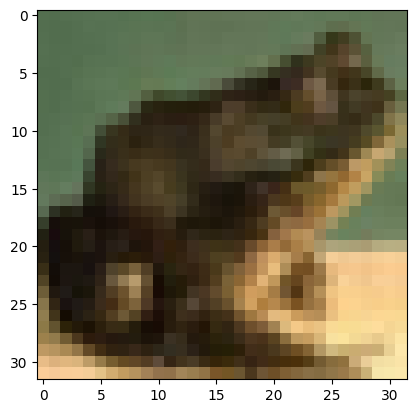

In [4]:
# load CIFAR10
download = True
dataset_class = datasets.CIFAR10
cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                        #  std=[0.247, 0.243, 0.261])
])

# dataset_transform = transforms.Compose(cifar10_transform)
cifar10_train = dataset_class('data/CIFAR10', train=True, download=download, transform=cifar10_transform)
cifar10_test = dataset_class('data/CIFAR10', train=False, download=download, transform=cifar10_transform)

cifar10_train_loader = DataLoader(cifar10_train, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(cifar10_train_loader):
    print(data.shape, target)
    print(data)
    # display the first image
    d = data[0].permute(1, 2, 0).numpy()
    # denomalrize
    # d = d * [0.247, 0.243, 0.261] + [0.4914, 0.4822, 0.4465]
    plt.imshow(d)
    plt.show()
    break

In [5]:
# train the MAE
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# mae_config = ViTMAEConfig()

# encoder = MAEEncoder(mae_config).to(device)
# decoder = MAEDecoder(mae_config).to(device)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
  0%|          | 1/391 [00:02<15:06,  2.33s/it]

Epoch 0, Iteration 0, Loss 4.036535739898682


 26%|██▌       | 101/391 [01:28<04:01,  1.20it/s]

Epoch 0, Iteration 100, Loss 0.00044823752250522375


 51%|█████▏    | 201/391 [02:58<02:53,  1.10it/s]

Epoch 0, Iteration 200, Loss 0.00024290935834869742


 77%|███████▋  | 301/391 [04:33<01:25,  1.05it/s]

Epoch 0, Iteration 300, Loss 0.00018889685452450067


100%|██████████| 391/391 [05:58<00:00,  1.09it/s]


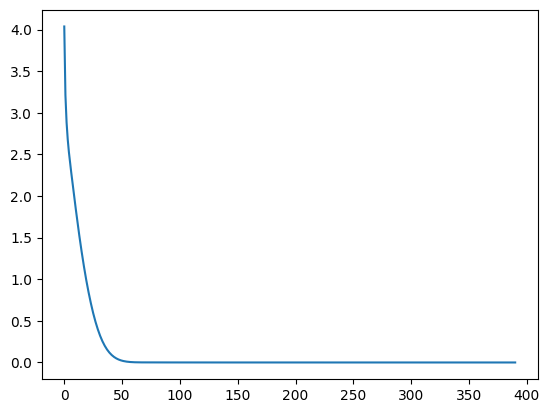

In [5]:
from transformers import AutoImageProcessor

train_loader = DataLoader(cifar10_train, batch_size=128, shuffle=True)

# optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
# train the model
num_epochs = 1

all_losses = []

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    for i, (data, target) in enumerate(tqdm(train_loader)):
        # data = data.to(device)
        optimizer.zero_grad()
        inputs = image_processor(data, return_tensors="pt").pixel_values.to(device)
        # print(inputs.keys())
        outputs = encoder(inputs)

        latent = outputs.last_hidden_state
        ids_restore = outputs.ids_restore
        mask = outputs.mask

        decoder_outputs = decoder(latent, ids_restore)
        
        logits = decoder_outputs.logits
        loss = forward_loss(inputs, logits, mask, config=mae_config)
        
        # print(loss)
        loss.backward()
        optimizer.step()
        all_losses.append(loss.item())

        if i % 100 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss {loss.item()}")

        # break

plt.plot(all_losses)



torch.Size([1000, 38400]) (1000,)
(1000, 2)


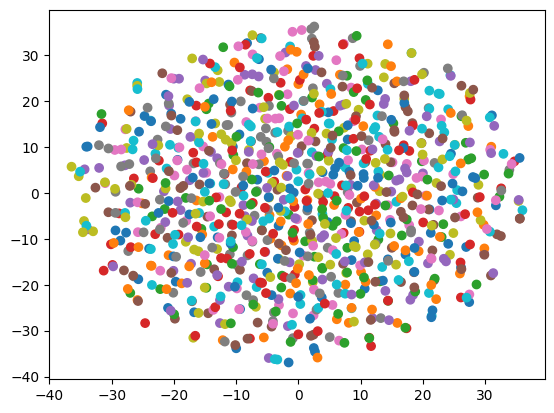

In [9]:
# plot tsne on the latent space

test_loader = DataLoader(cifar10_test, batch_size=1000, shuffle=True)

all_latent = None
all_targets = []

for i, (data, target) in enumerate(test_loader):
    inputs = image_processor(data, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = encoder(inputs)
        latent = outputs.last_hidden_state
        # print(latent.shape)
        latent = latent.detach().cpu()
        # reshape the latent
        latent = latent.view(latent.size(0), -1)
        # print(latent.shape)
        if all_latent is None:
            all_latent = latent
        else:
            all_latent = torch.cat((all_latent, latent), dim=0)
        all_targets.append(target)
    break

all_targets = torch.cat(all_targets, dim=0).numpy()
print(all_latent.shape, all_targets.shape)

# tsne
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(all_latent)
print(tsne_results.shape)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_targets, cmap='tab10')
plt.show()


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


torch.Size([1000, 38400]) (1000,)
(1000, 2)


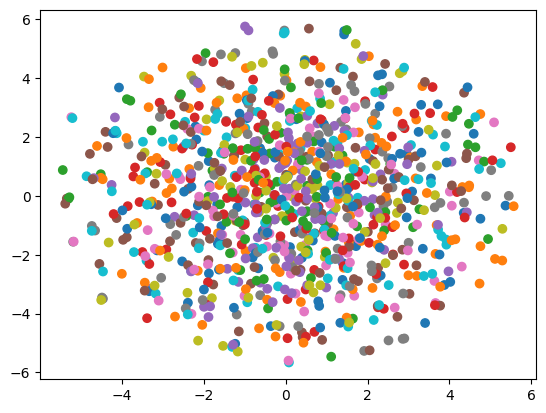

In [11]:
# load pretrained model
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)


test_loader = DataLoader(cifar10_test, batch_size=1000, shuffle=True)

all_latent = None
all_targets = []

for i, (data, target) in enumerate(test_loader):
    inputs = image_processor(images=data, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = model(inputs, output_hidden_states=True)
        # outputs = encoder(inputs)
        # print(outputs.keys())
        # print(latent.shape)
        latent = outputs.hidden_states[-1].detach().cpu()
        # latent = latent.detach().cpu()
        # reshape the latent
        latent = latent.view(latent.size(0), -1)
        # print(latent.shape)
        if all_latent is None:
            all_latent = latent
        else:
            all_latent = torch.cat((all_latent, latent), dim=0)
        all_targets.append(target)
    break

all_targets = torch.cat(all_targets, dim=0).numpy()
print(all_latent.shape, all_targets.shape)

# tsne
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(all_latent)
print(tsne_results.shape)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_targets, cmap='tab10')
plt.show()

100%|██████████| 79/79 [00:39<00:00,  2.01it/s]

Epoch 5, Accuracy 0.2276


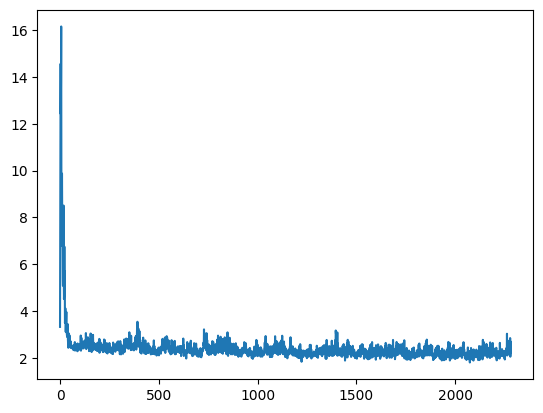

In [14]:
# linear probing on cifar 10 with learnable linear layer

# classification = nn.Linear(38400, 10).to(device)

# cifar10_train_loader = DataLoader(cifar10_train, batch_size=128, shuffle=True)
# cifar10_test_loader = DataLoader(cifar10_test, batch_size=128, shuffle=True)

# # optimizer
# optimizer = optim.Adam(classification.parameters(), lr=1e-4)
# all_losses = []
# num_epochs = 10
# for epoch in range(num_epochs):
#     classification.train()
#     for i, (data, target) in enumerate(tqdm(cifar10_train_loader)):
#         optimizer.zero_grad()
#         inputs = image_processor(data, return_tensors="pt").pixel_values.to(device)
#         with torch.no_grad():
#             outputs = model(inputs, output_hidden_states=True)
#             latent = outputs.hidden_states[-1].detach().cpu()
#             latent = latent.view(latent.size(0), -1)
#         logits = classification(latent.to(device))
#         loss = F.cross_entropy(logits, target.to(device))
#         loss.backward()
#         all_losses.append(loss.item())
#         optimizer.step()

#         if i % 100 == 0:
#             print(f"Epoch {epoch}, Iteration {i}, Loss {loss.item()}")

plt.plot(all_losses)

# test the model
classification.eval()
correct = 0
total = 0
for i, (data, target) in enumerate(tqdm(cifar10_test_loader)):
    inputs = image_processor(data, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = model(inputs, output_hidden_states=True)
        latent = outputs.hidden_states[-1].detach().cpu()
        latent = latent.view(latent.size(0), -1)
    logits = classification(latent.to(device))
    _, predicted = torch.max(logits, 1)
    total += target.size(0)
    correct += (predicted == target.to(device)).sum().item()
print(f"Epoch {epoch}, Accuracy {correct / total}")